Projeto sobre Vendas de Jogos

Aluno: Bruno Felipe Soares Santos
bfss@cesar.school

A base de dados é do Kaggle

https://www.kaggle.com/datasets/thedevastator/global-video-game-sales

# Import de biliotecas

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import math

# Import de dataset e tratamento

In [2]:
file_path = "/content/vgsales.csv"
df = pd.read_csv(file_path)

In [3]:
df.head(10)

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37
5,6,Tetris,GB,1989.0,Puzzle,Nintendo,23.20,2.26,4.22,0.58,30.26
6,7,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,11.38,9.23,6.50,2.90,30.01
7,8,Wii Play,Wii,2006.0,Misc,Nintendo,14.03,9.20,2.93,2.85,29.02
8,9,New Super Mario Bros. Wii,Wii,2009.0,Platform,Nintendo,14.59,7.06,4.70,2.26,28.62
9,10,Duck Hunt,NES,1984.0,Shooter,Nintendo,26.93,0.63,0.28,0.47,28.31


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16598 non-null  int64  
 1   Name          16598 non-null  object 
 2   Platform      16598 non-null  object 
 3   Year          16327 non-null  float64
 4   Genre         16598 non-null  object 
 5   Publisher     16540 non-null  object 
 6   NA_Sales      16598 non-null  float64
 7   EU_Sales      16598 non-null  float64
 8   JP_Sales      16598 non-null  float64
 9   Other_Sales   16598 non-null  float64
 10  Global_Sales  16598 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


In [5]:
df.describe()

,Rank,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
count,16598.000000,16327.000000,16598.000000,16598.000000,16598.000000,16598.000000,16598.000000
mean,8300.605254,2006.406443,0.264667,0.146652,0.077782,0.048063,0.537441
std,4791.853933,5.828981,0.816683,0.505351,0.309291,0.188588,1.555028
min,1.000000,1980.000000,0.000000,0.000000,0.000000,0.000000,0.010000
25%,4151.250000,2003.000000,0.000000,0.000000,0.000000,0.000000,0.060000
50%,8300.500000,2007.000000,0.080000,0.020000,0.000000,0.010000,0.170000
75%,12449.750000,2010.000000,0.240000,0.110000,0.040000,0.040000,0.470000
max,16600.000000,2020.000000,41.490000,29.020000,10.220000,10.570000,82.740000


In [7]:
# Removendo valores nulos em 'Year' e convertendo para inteiro
df = df.dropna(subset=['Year']).copy()
df.loc[:, 'Year'] = df['Year'].astype(int)
df = df.sort_values('Year')

In [8]:
# Apagando os dados de anos após 2015
df = df[df['Year'] <= 2015]
# O dataset não contempla todos os lançamentos de 2016 pra frente, prejudicando a análise e previsão mais a frente

In [9]:
# Substituindo valores nulos em 'Publisher' por 'Desconhecido'
df['Publisher'] = df['Publisher'].fillna('Desconhecido')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15979 entries, 6896 to 15268
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          15979 non-null  int64  
 1   Name          15979 non-null  object 
 2   Platform      15979 non-null  object 
 3   Year          15979 non-null  float64
 4   Genre         15979 non-null  object 
 5   Publisher     15979 non-null  object 
 6   NA_Sales      15979 non-null  float64
 7   EU_Sales      15979 non-null  float64
 8   JP_Sales      15979 non-null  float64
 9   Other_Sales   15979 non-null  float64
 10  Global_Sales  15979 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


In [11]:
df.head(10)

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
6896,6898,Checkers,2600,1980.0,Misc,Atari,0.22,0.01,0.0,0.00,0.24
2669,2671,Boxing,2600,1980.0,Fighting,Activision,0.72,0.04,0.0,0.01,0.77
5366,5368,Freeway,2600,1980.0,Action,Activision,0.32,0.02,0.0,0.00,0.34
1969,1971,Defender,2600,1980.0,Misc,Atari,0.99,0.05,0.0,0.01,1.05
1766,1768,Kaboom!,2600,1980.0,Misc,Activision,1.07,0.07,0.0,0.01,1.15
6317,6319,Bridge,2600,1980.0,Misc,Activision,0.25,0.02,0.0,0.00,0.27
544,545,Missile Command,2600,1980.0,Shooter,Atari,2.56,0.17,0.0,0.03,2.76
258,259,Asteroids,2600,1980.0,Shooter,Atari,4.00,0.26,0.0,0.05,4.31
4025,4027,Ice Hockey,2600,1980.0,Sports,Activision,0.46,0.03,0.0,0.01,0.49
4517,4519,Barnstorming,2600,1981.0,Action,Activision,0.40,0.02,0.0,0.00,0.43


# Análise do dataset

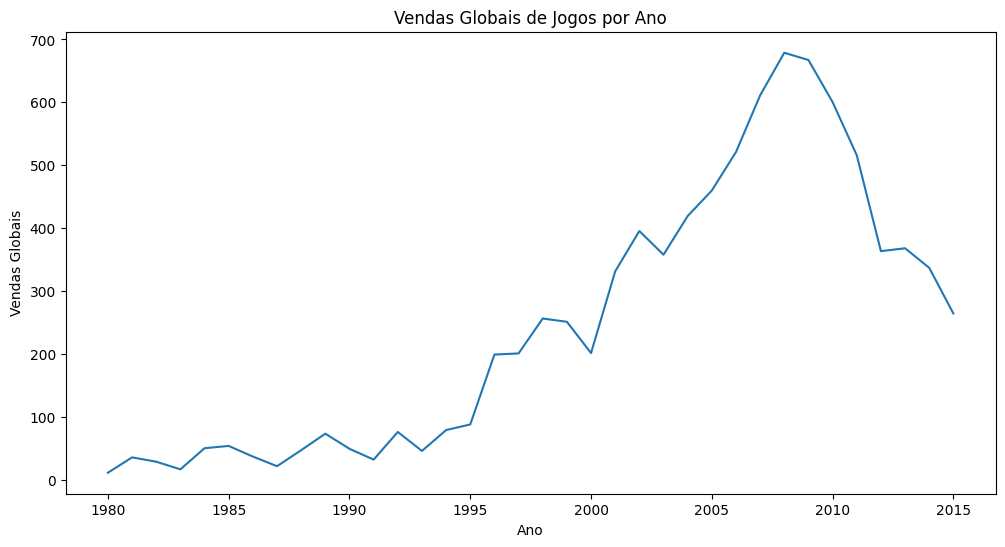

In [12]:
# Análise da distribuição das vendas globais por ano
plt.figure(figsize=(12, 6))
plt.plot(df.groupby('Year')['Global_Sales'].sum().index, df.groupby('Year')['Global_Sales'].sum().values)
plt.xlabel('Ano')
plt.ylabel('Vendas Globais')
plt.title('Vendas Globais de Jogos por Ano')
plt.show()

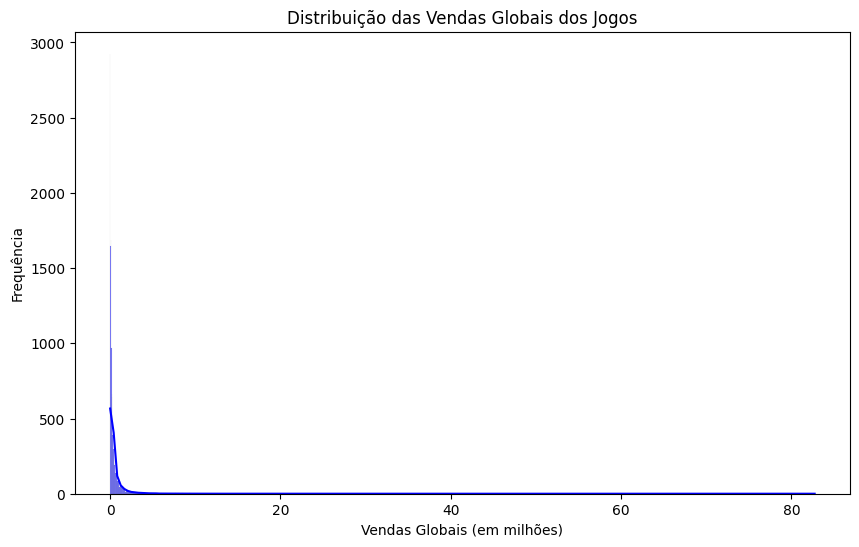

In [13]:
# Análise da distribuição das vendas globais - frequência
plt.figure(figsize=(10, 6))
sns.histplot(df['Global_Sales'], kde=True, color='blue')
plt.title('Distribuição das Vendas Globais dos Jogos')
plt.xlabel('Vendas Globais (em milhões)')
plt.ylabel('Frequência')
plt.show()

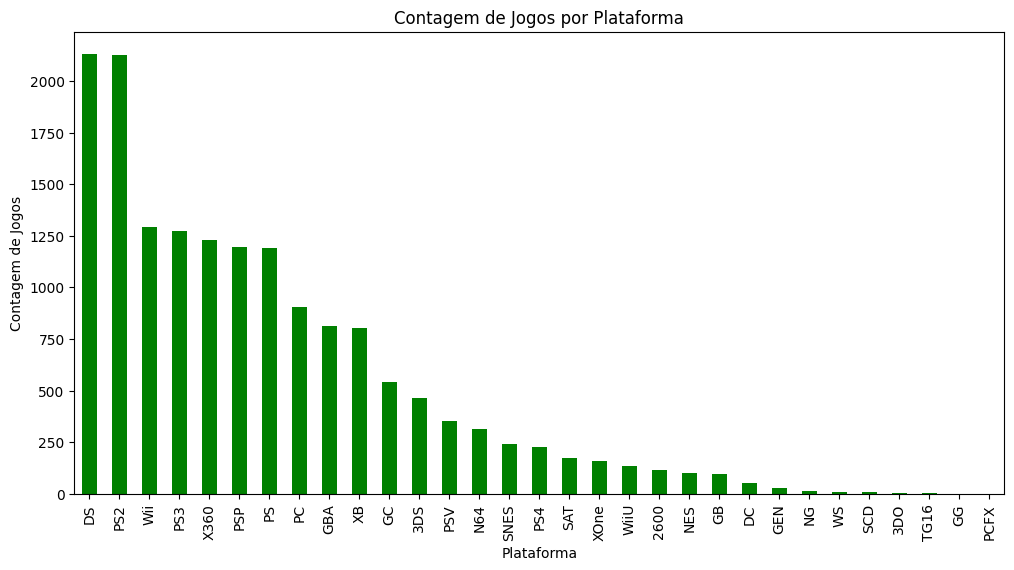

In [14]:
# Contagem de jogos por plataforma
plt.figure(figsize=(12, 6))
df['Platform'].value_counts().plot(kind='bar', color='green')
plt.title('Contagem de Jogos por Plataforma')
plt.xlabel('Plataforma')
plt.ylabel('Contagem de Jogos')
plt.xticks(rotation=90)
plt.show()

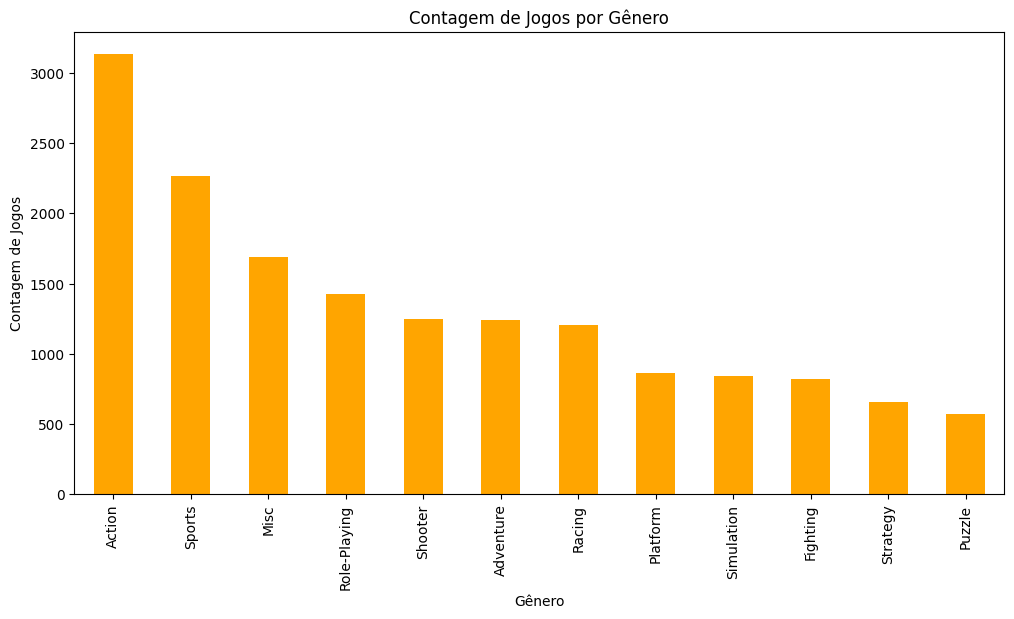

In [15]:
# Contagem de jogos por gênero
plt.figure(figsize=(12, 6))
df['Genre'].value_counts().plot(kind='bar', color='orange')
plt.title('Contagem de Jogos por Gênero')
plt.xlabel('Gênero')
plt.ylabel('Contagem de Jogos')
plt.xticks(rotation=90)
plt.show()

Com isso, decidi seguir com a ideia de vendas globais x ano, agrupando todas as vendas naquele ano

## Novo dataset

In [16]:
# Agregando as vendas globais por ano
df['Year'] = pd.to_datetime(df['Year'], format='%Y')
df_ano = df.groupby(df['Year'].dt.year)['Global_Sales'].sum()

In [17]:
df_ano.head(10)

,Global_Sales
Year,
1980,11.38
1981,35.77
1982,28.86
1983,16.79
1984,50.36
1985,53.94
1986,37.07
1987,21.74
1988,47.22


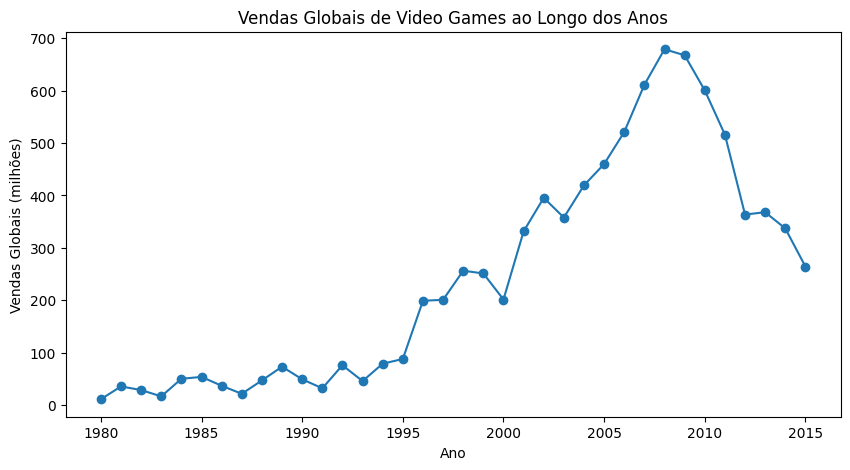

In [18]:
# Análise descritiva
df_ano.plot(kind='line', marker='o', figsize=(10, 5), legend=False)
plt.xlabel("Ano")
plt.ylabel("Vendas Globais (milhões)")
plt.title("Vendas Globais de Video Games ao Longo dos Anos")
plt.show()

In [19]:
df_ano.info()

<class 'pandas.core.series.Series'>
Index: 36 entries, 1980 to 2015
Series name: Global_Sales
Non-Null Count  Dtype  
--------------  -----  
36 non-null     float64
dtypes: float64(1)
memory usage: 432.0 bytes


In [20]:
df_ano.describe()

,Global_Sales
count,36.000000
mean,243.030278
std,212.269089
min,11.380000
25%,48.847500
50%,201.270000
75%,374.962500
max,678.900000


# Modelos

## ARIMA

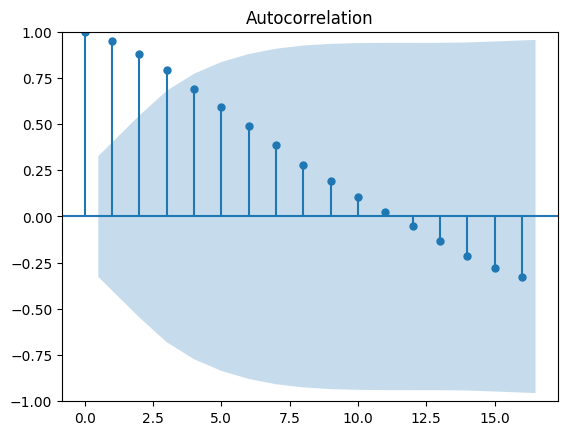

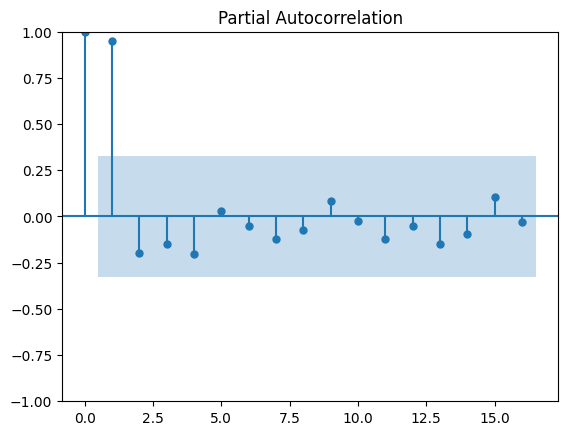

In [21]:
plot_acf(df_ano)
plot_pacf(df_ano)
plt.show()

Com isso, seguirei com o arima 1,1,2

In [23]:
# Criando modelo ARIMA
model_arima = ARIMA(df_ano, order=(1, 1, 2))
model_arima_fit = model_arima.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [25]:
# Prevendo os próximos 5 anos
previsao = model_arima_fit.forecast(steps=5)
print(previsao)

36    239.222822
37    221.658644
38    209.665174
39    201.475591
40    195.883441
Name: predicted_mean, dtype: float64


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


## LSTM

In [28]:
# Normalizando os dados para o LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_ano.values.reshape(-1, 1))

In [29]:
# Função para criar dados de treino e teste
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

In [162]:
# Preparando os dados
time_step = 2
X, y = create_dataset(scaled_data, time_step)

In [163]:
# Dividindo em treino e teste
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [164]:
# Modelagem LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

model_lstm = Sequential()
model_lstm.add(LSTM(units=100, return_sequences=True, input_shape=(time_step, 1)))
model_lstm.add(LSTM(units=50, return_sequences=False))
model_lstm.add(Dense(units=1))
model_lstm.add(Dropout(0.2))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [171]:
model_lstm.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
model_lstm.fit(X_train, y_train, epochs=100, batch_size=50, callbacks=[early_stopping])

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.0603
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.0478
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0600
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.0788
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.0622
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0271
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.0232
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.0203
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0255
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0360
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.0275
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.0519
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0133
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0185
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0413
Epoch 16/100
1/

In [172]:
# Previsões
predictions = model_lstm.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


In [173]:
# Invertendo a normalização
predictions_rescaled = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

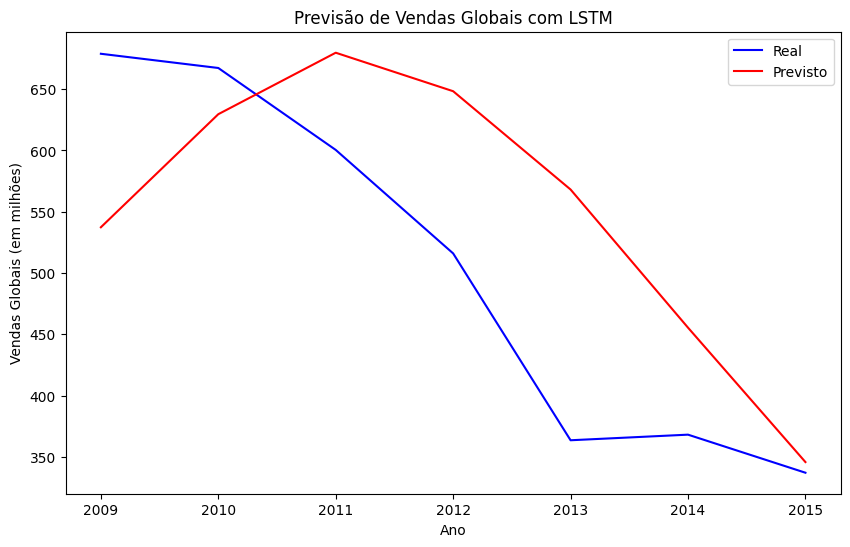

In [174]:
# Plotando os resultados
plt.figure(figsize=(10, 6))
plt.plot(df_ano.index[-len(y_test):], y_test_rescaled, color='blue', label='Real')
plt.plot(df_ano.index[-len(y_test):], predictions_rescaled, color='red', label='Previsto')
plt.title('Previsão de Vendas Globais com LSTM')
plt.xlabel('Ano')
plt.ylabel('Vendas Globais (em milhões)')
plt.legend()
plt.show()

# Avaliação

In [169]:
# Métricas do ARIMA
mse_arima = mean_squared_error(df_ano[-5:], previsao)
rmse_arima = math.sqrt(mse_arima)
mae_arima = mean_absolute_error(df_ano[-5:], previsao)

print(f'MSE ARIMA: {mse_arima}')
print(f'RMSE ARIMA: {rmse_arima}')
print(f'MAE ARIMA: {mae_arima}')

MSE ARIMA: 28983.115061091376
RMSE ARIMA: 170.2442805532432
MAE ARIMA: 156.24486583574


In [175]:
# Métricas do LSTM
mse_lstm = mean_squared_error(y_test_rescaled, predictions_rescaled)
rmse_lstm = math.sqrt(mse_lstm)
mae_lstm = mean_absolute_error(y_test_rescaled, predictions_rescaled)

print(f'MSE LSTM: {mse_lstm}')
print(f'RMSE LSTM: {rmse_lstm}')
print(f'MAE LSTM: {mae_lstm}')

MSE LSTM: 13546.698644151722
RMSE LSTM: 116.3902858667841
MAE LSTM: 98.79058872767853
